In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

In [47]:
from fim import apriori
from fim import fpgrowth

In [48]:
df=pd.read_csv("ravdess_features.csv")

In [49]:
dfcopy=df.copy()

### Filling missing values

Intensity

In [50]:
df_empty=df[df["intensity"].isna()]
df_full=df[df["intensity"].notnull()]

In [51]:
df_full_train, df_full_test = train_test_split(df_full, test_size=0.3, random_state=100)

In [52]:
x_train = df_full_train["mfcc_min"].values.reshape(-1, 1)
y_train = df_full_train["intensity"].values

x_test = df_full_test["mfcc_min"].values.reshape(-1, 1)
y_test = df_full_test["intensity"].values

x = df_empty["mfcc_min"].values.reshape(-1, 1)
y = df_empty["intensity"]

In [53]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [54]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.950
MSE: 3.518
MAE: 1.518


In [55]:
y = reg.predict(x)

na = df["intensity"].isna()
df.loc[na, "intensity"] = y

Vocal channel

In [56]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df=df.drop(columns=["modality", "repetition", "actor", "channels","sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max"])

In [57]:
df_full_VC = df[df["vocal_channel"].notna()]
df_empty_VC = df[df["vocal_channel"].isna()]

In [58]:
X_VC = df_full_VC.drop("vocal_channel", axis=1).values
Y_VC = df_full_VC["vocal_channel"].values

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_VC, Y_VC, test_size=0.3, random_state=0)

In [60]:
dt = DecisionTreeClassifier(max_depth= 100, min_samples_leaf= 0.005, min_samples_split= 0.002)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=100, min_samples_leaf=0.005,
                       min_samples_split=0.002)

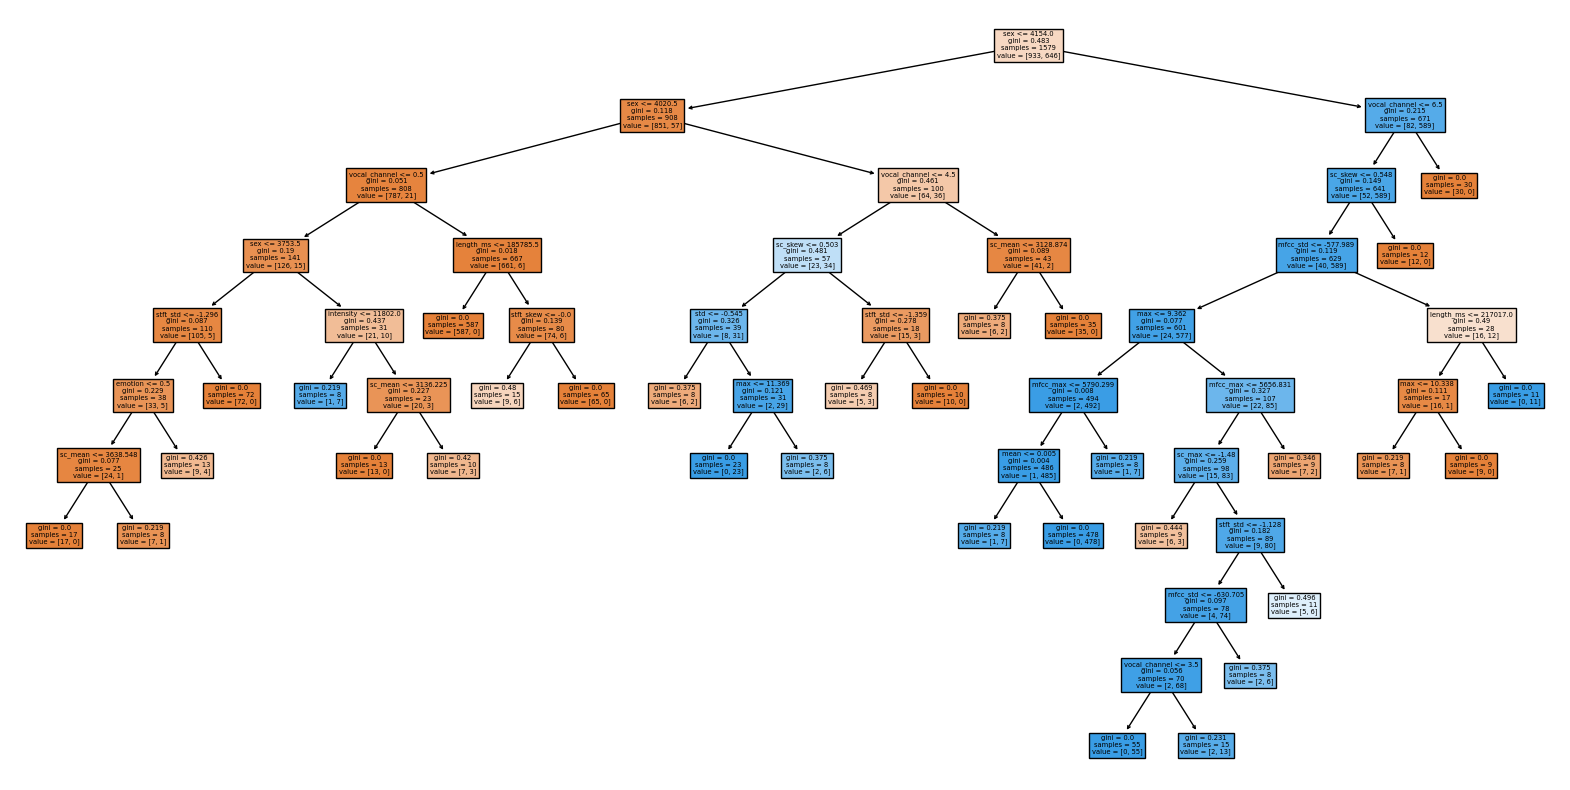

In [61]:
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=df_full_VC.columns, filled=True)
plt.show()

In [62]:
y_test_pred_VC = dt.predict(X_test)
print(accuracy_score(Y_test, y_test_pred_VC))
print(f1_score(Y_test, y_test_pred_VC, average="macro"))

0.946824224519941
0.9448846675712348


In [63]:
print(classification_report(Y_test, y_test_pred_VC))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       402
         1.0       0.93      0.93      0.93       275

    accuracy                           0.95       677
   macro avg       0.94      0.94      0.94       677
weighted avg       0.95      0.95      0.95       677



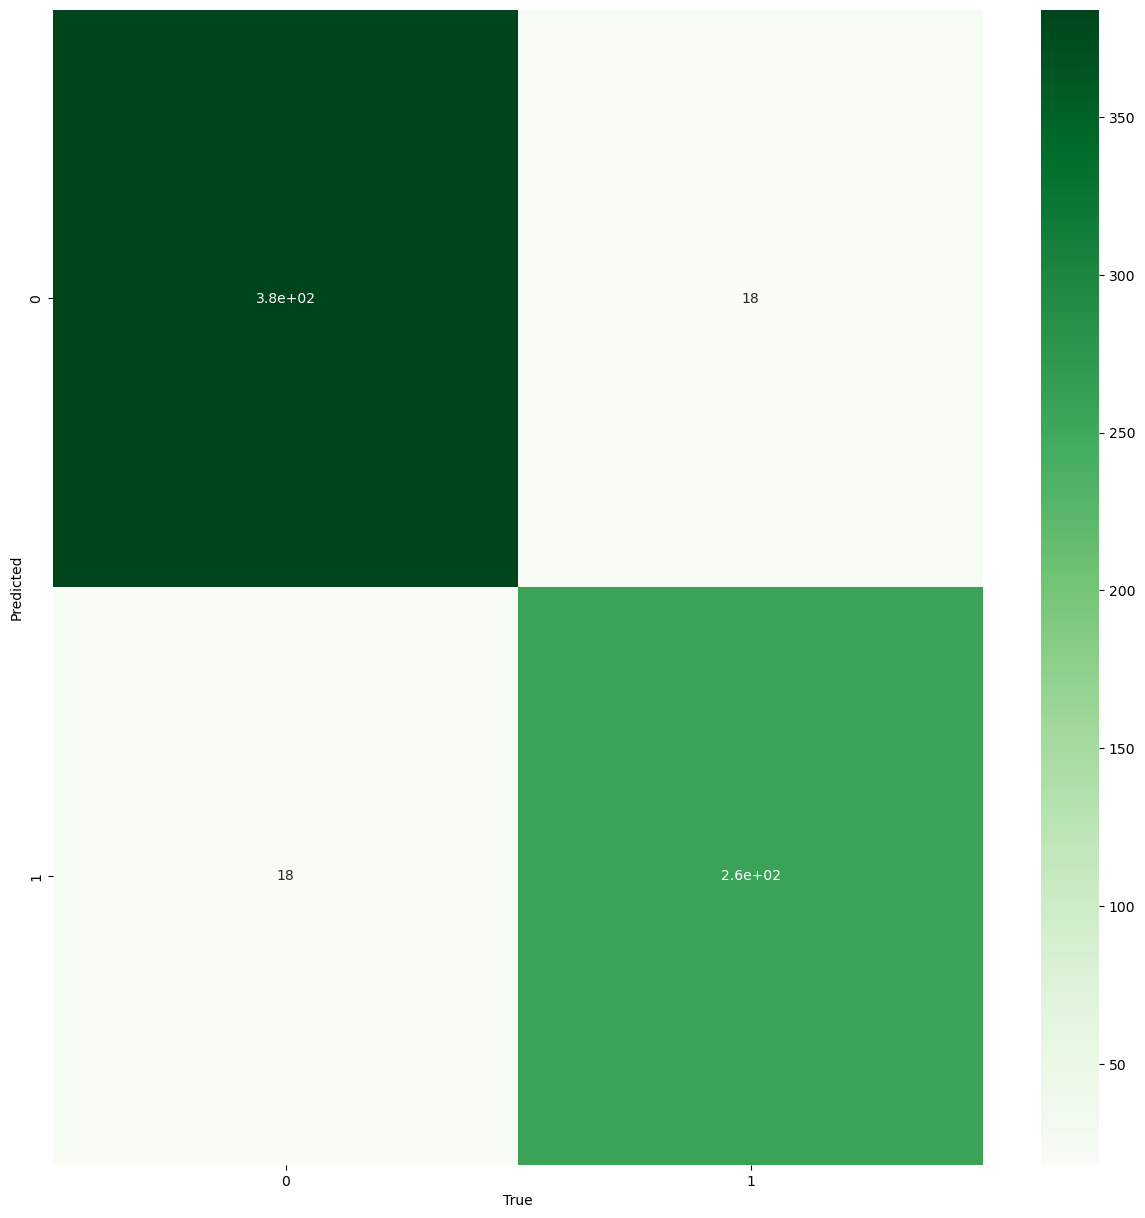

In [64]:
plt.figure(figsize=(15,15))
cf = confusion_matrix(Y_test, y_test_pred_VC)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [65]:
y_test_pred_proba_VC = dt.predict_proba(X_test)

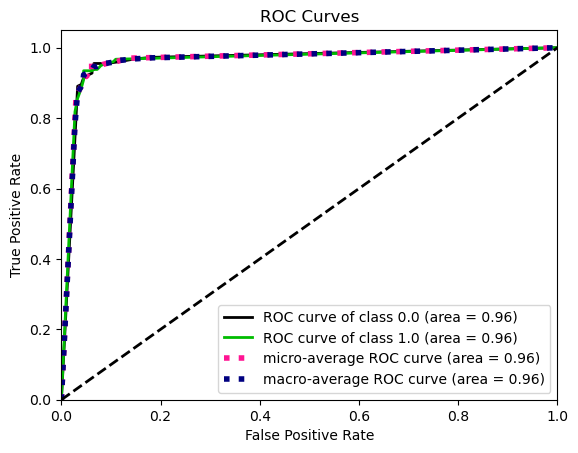

0.9635006784260516


In [66]:
plot_roc(Y_test, dt.predict_proba(X_test))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba_VC[:,1], multi_class="ovr", average="macro"))

In [67]:
df_empty_VC = df_empty_VC.drop('vocal_channel', axis=1)
prediction = dt.predict(df_empty_VC)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [68]:
df_empty_VC.insert(0, 'vocal_channel', prediction)

In [69]:
frames = [df_full_VC, df_empty_VC]
df = pd.concat(frames)

In [70]:
df[df["vocal_channel"].isna()]

,vocal_channel,emotion,emotional_intensity,statement,sex,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,...,stft_mean,stft_std,stft_kur,stft_skew,mean,std,min,max,kur,skew


Frame count

In [71]:
df_empty=df[df["frame_count"] == -1]
df_full=df[df["frame_count"] != -1]

In [72]:
df_full_train, df_full_test = train_test_split(df_full, test_size=0.3, random_state=100)

In [73]:
x_train = df_full_train["length_ms"].values.reshape(-1, 1)
y_train = df_full_train["frame_count"].values

x_test = df_full_test["length_ms"].values.reshape(-1, 1)
y_test = df_full_test["frame_count"].values

x = df_empty["length_ms"].values.reshape(-1, 1)
y = df_empty["frame_count"]

In [74]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [75]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 1.000
MSE: 197.578
MAE: 12.121


In [76]:
y = reg.predict(x)

na = df["frame_count"] == -1
df.loc[na, "intensity"] = y

## Pattern mining preprocessing

In [77]:
df.head()

,vocal_channel,emotion,emotional_intensity,statement,sex,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,...,stft_mean,stft_std,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,0.0,0,0,0,1,3737,179379.0,-36.793432,16995,-33.485947,...,0.415250,0.335533,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,0.0,1,0,0,1,3904,187387.0,-33.841674,13906,-29.502108,...,0.417488,0.352380,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
4,1.0,2,1,0,1,4404,211411.0,-31.214503,15137,-31.405996,...,0.415974,0.350655,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
5,0.0,0,0,0,1,3570,171371.0,-36.312244,12143,-30.500889,...,0.349669,0.345256,-1.098179,0.576157,2.519818e-07,0.015296,-0.122467,0.106171,12.775898,0.028186
6,0.0,1,0,0,1,3770,180980.0,-38.250586,14239,-30.177172,...,0.476312,0.346839,-1.425898,0.027192,-1.571576e-07,0.013860,-0.132965,0.148987,14.273623,0.011188


In [78]:
df["length_bin"] = pd.qcut(df["length_ms"], 4)
df["frame_count_bin"] = pd.qcut(df["frame_count"], 4)
df["intensity_bin"] = pd.qcut(df["intensity"], 4)
df["zero_crossings_sum_bin"] = pd.qcut(df["zero_crossings_sum"], 4)
df["mfcc_mean_bin"] = pd.qcut(df["mfcc_mean"], 4)
df["mfcc_std_bin"] = pd.qcut(df["mfcc_std"], 4)
df["mfcc_min_bin"] = pd.qcut(df["mfcc_min"], 4)
df["mfcc_max_bin"] = pd.qcut(df["mfcc_max"], 4)
df["sc_mean_bin"] = pd.qcut(df["sc_mean"], 4)
df["sc_std_bin"] = pd.qcut(df["sc_std"], 4)
df["sc_max_bin"] = pd.qcut(df["sc_max"], 4)
df["sc_kur_bin"] = pd.qcut(df["sc_kur"], 4)
df["sc_skew_bin"] = pd.qcut(df["sc_skew"], 4)
df["stft_mean_bin"] = pd.qcut(df["stft_mean"], 4)
df["stft_std_bin"] = pd.qcut(df["stft_std"], 4)
df["stft_kur_bin"] = pd.qcut(df["stft_kur"], 4)
df["stft_skew_bin"] = pd.qcut(df["stft_skew"], 4)
df["mean_bin"] = pd.qcut(df["mean"], 4)
df["std_bin"] = pd.qcut(df["std"], 4)
df["max_bin"] = pd.qcut(df["max"], 4)
df["min_bin"] = pd.qcut(df["min"], 4)
df["kur_bin"] = pd.qcut(df["kur"], 4)
df["skew_bin"] = pd.qcut(df["skew"], 4)

df = df.drop(columns = ["length_ms", "frame_count", "intensity", "zero_crossings_sum", "mfcc_mean", "mfcc_std", "mfcc_min", "mfcc_max",
                        "sc_mean", "sc_std", "sc_max", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_kur", "stft_skew",
                        "mean", "std", "max", "min", "kur", "skew"])

In [79]:
df["length_bin"] = df.length_bin.astype(str) + "_length"
df["frame_count_bin"] = df.frame_count_bin.astype(str) + "_frame_count"
df["intensity_bin"] = df.intensity_bin.astype(str) + "_intensity"
df["zero_crossings_sum_bin"] = df.zero_crossings_sum_bin.astype(str) + "_zero_crossings_sum"
df["mfcc_mean_bin"] = df.mfcc_mean_bin.astype(str) + "_mfcc_mean"
df["mfcc_std_bin"] = df.mfcc_std_bin.astype(str) + "_mfcc_std"
df["mfcc_min_bin"] = df.mfcc_min_bin.astype(str) + "_mfcc_min"
df["mfcc_max_bin"] = df.mfcc_max_bin.astype(str) + "_mfcc_max"
df["sc_mean_bin"] = df.sc_mean_bin.astype(str) + "_sc_mean"
df["sc_std_bin"] = df.sc_std_bin.astype(str) + "_sc_std"
df["sc_max_bin"] = df.sc_max_bin.astype(str) + "_sc_max"
df["sc_kur_bin"] = df.sc_kur_bin.astype(str) + "_sc_kur"
df["sc_skew_bin"] = df.sc_skew_bin.astype(str) + "_sc_skew"
df["stft_mean_bin"] = df.stft_mean_bin.astype(str) + "_stft_mean"
df["stft_std_bin"] = df.stft_std_bin.astype(str) + "_stft_std"
df["stft_kur_bin"] = df.stft_kur_bin.astype(str) + "_stft_kur"
df["stft_skew_bin"] = df.stft_skew_bin.astype(str) + "_stft_skew"
df["mean_bin"] = df.mean_bin.astype(str) + "_mean"
df["std_bin"] = df.std_bin.astype(str) + "_std"
df["max_bin"] = df.max_bin.astype(str) + "_max"
df["min_bin"] = df.min_bin.astype(str) + "_min"
df["kur_bin"] = df.kur_bin.astype(str) + "_kur"
df["skew_bin"] = df.skew_bin.astype(str) + "_skew"

In [80]:
df["emotion"]=df["emotion"].replace([0,1,2,3,4,5,6,7],["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"])
df["emotional_intensity"]=df["emotional_intensity"].replace([0,1],["normal", "strong"])
df["sex"]=df["sex"].replace([0,1],["M", "F"])
df["statement"]=df["statement"].replace([0,1],["Dogs are sitting by the door", "Kids are talking by the door"])
df["vocal_channel"]=df["vocal_channel"].replace([0,1],["speech", "song"])
df =df.drop(columns=["vocal_channel", "emotional_intensity", "length_bin", "statement", "frame_count_bin", "sex"])
df.head()

,emotion,intensity_bin,zero_crossings_sum_bin,mfcc_mean_bin,mfcc_std_bin,mfcc_min_bin,mfcc_max_bin,sc_mean_bin,sc_std_bin,sc_max_bin,...,stft_mean_bin,stft_std_bin,stft_kur_bin,stft_skew_bin,mean_bin,std_bin,max_bin,min_bin,kur_bin,skew_bin
0,fearful,"(-37.179, -31.509]_intensity","(14966.0, 30153.0]_zero_crossings_sum","(-43.814, -31.829]_mfcc_mean","(122.624, 136.524]_mfcc_std","(-760.983, -692.89]_mfcc_min","(126.25, 180.081]_mfcc_max","(5775.96, 7655.336]_sc_mean","(3025.432, 3433.835]_sc_std","(12091.886, 17477.54]_sc_max",...,"(0.213, 0.415]_stft_mean","(0.334, 0.349]_stft_std","(-1.292, -1.153]_stft_kur","(0.336, 1.466]_stft_skew","(-9.81e-08, 8.36e-07]_mean","(0.0139, 0.0262]_std","(0.11, 0.224]_max","(-0.202, -0.104]_min","(6.52, 9.829]_kur","(0.263, 1.8]_skew"
1,angry,"(-37.179, -31.509]_intensity","(12383.5, 14966.0]_zero_crossings_sum","(-31.829, -28.681]_mfcc_mean","(122.624, 136.524]_mfcc_std","(-760.983, -692.89]_mfcc_min","(201.697, 218.185]_mfcc_max","(5122.712, 5775.96]_sc_mean","(3768.503, 4819.783]_sc_std","(11516.034, 12000.293]_sc_max",...,"(0.415, 0.476]_stft_mean","(0.349, 0.392]_stft_std","(-1.391, -1.292]_stft_kur","(0.126, 0.336]_stft_skew","(-9.81e-08, 8.36e-07]_mean","(0.0139, 0.0262]_std","(0.224, 0.999]_max","(-1.0, -0.202]_min","(14.085, 59.086]_kur","(0.263, 1.8]_skew"
4,happy,"(-31.509, 253058.198]_intensity","(14966.0, 30153.0]_zero_crossings_sum","(-31.829, -28.681]_mfcc_mean","(83.61999999999999, 122.624]_mfcc_std","(-760.983, -692.89]_mfcc_min","(126.25, 180.081]_mfcc_max","(5122.712, 5775.96]_sc_mean","(3433.835, 3768.503]_sc_std","(12000.293, 12091.886]_sc_max",...,"(0.415, 0.476]_stft_mean","(0.349, 0.392]_stft_std","(-1.391, -1.292]_stft_kur","(0.126, 0.336]_stft_skew","(8.36e-07, 0.00122]_mean","(0.0262, 0.152]_std","(0.224, 0.999]_max","(-0.202, -0.104]_min","(6.52, 9.829]_kur","(0.263, 1.8]_skew"
5,fearful,"(-37.179, -31.509]_intensity","(10362.5, 12383.5]_zero_crossings_sum","(-31.829, -28.681]_mfcc_mean","(122.624, 136.524]_mfcc_std","(-760.983, -692.89]_mfcc_min","(201.697, 218.185]_mfcc_max","(2360.8799999999997, 4563.685]_sc_mean","(3768.503, 4819.783]_sc_std","(12000.293, 12091.886]_sc_max",...,"(0.213, 0.415]_stft_mean","(0.334, 0.349]_stft_std","(-1.153, 0.795]_stft_kur","(0.336, 1.466]_stft_skew","(-9.81e-08, 8.36e-07]_mean","(0.0139, 0.0262]_std","(0.0555, 0.11]_max","(-0.202, -0.104]_min","(9.829, 14.085]_kur","(0.00426, 0.263]_skew"
6,angry,"(-43.343, -37.179]_intensity","(12383.5, 14966.0]_zero_crossings_sum","(-31.829, -28.681]_mfcc_mean","(136.524, 151.385]_mfcc_std","(-826.464, -760.983]_mfcc_min","(218.185, 280.174]_mfcc_max","(5122.712, 5775.96]_sc_mean","(3768.503, 4819.783]_sc_std","(12091.886, 17477.54]_sc_max",...,"(0.476, 0.531]_stft_mean","(0.334, 0.349]_stft_std","(-1.6709999999999998, -1.391]_stft_kur","(-0.0943, 0.126]_stft_skew","(-1.39e-06, -9.81e-08]_mean","(0.00679, 0.0139]_std","(0.11, 0.224]_max","(-0.202, -0.104]_min","(14.085, 59.086]_kur","(0.00426, 0.263]_skew"


In [81]:
X = df.values.tolist()
X[0]

['fearful',
 '(-37.179, -31.509]_intensity',
 '(14966.0, 30153.0]_zero_crossings_sum',
 '(-43.814, -31.829]_mfcc_mean',
 '(122.624, 136.524]_mfcc_std',
 '(-760.983, -692.89]_mfcc_min',
 '(126.25, 180.081]_mfcc_max',
 '(5775.96, 7655.336]_sc_mean',
 '(3025.432, 3433.835]_sc_std',
 '(12091.886, 17477.54]_sc_max',
 '(-1.309, -0.983]_sc_kur',
 '(0.0985, 0.348]_sc_skew',
 '(0.213, 0.415]_stft_mean',
 '(0.334, 0.349]_stft_std',
 '(-1.292, -1.153]_stft_kur',
 '(0.336, 1.466]_stft_skew',
 '(-9.81e-08, 8.36e-07]_mean',
 '(0.0139, 0.0262]_std',
 '(0.11, 0.224]_max',
 '(-0.202, -0.104]_min',
 '(6.52, 9.829]_kur',
 '(0.263, 1.8]_skew']

# Pattern mining

## Apriori

In [82]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

### Frequent itemset

In [83]:
supp = 2  # 2%
supp = 20  # 25%
zmin =4  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((-31.509, 253058.198]_intensity, (0.0262, 0.1...",20.676998
1,"((-31.509, 253058.198]_intensity, (0.0262, 0.1...",20.350734
2,"((-31.509, 253058.198]_intensity, (0.0262, 0.1...",20.024470
3,"((-31.509, 253058.198]_intensity, (0.0262, 0.1...",20.024470
4,"((-31.509, 253058.198]_intensity, (0.0262, 0.1...",20.350734
5,"((0.0262, 0.152]_std, (-692.89, -461.489]_mfcc...",20.024470
6,"((151.385, 195.943]_mfcc_std, (-0.000348, 0.00...",20.921697


### Closed

In [84]:
supp = 2  # 2%
supp = 25  # 25%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="c", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support


### Maximal itemset

In [85]:
supp = 2  # 2%
supp = 25  # 25%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="m", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["maximal_itemset", "support"])

,maximal_itemset,support


## Support plot

Number of itemset vs Support

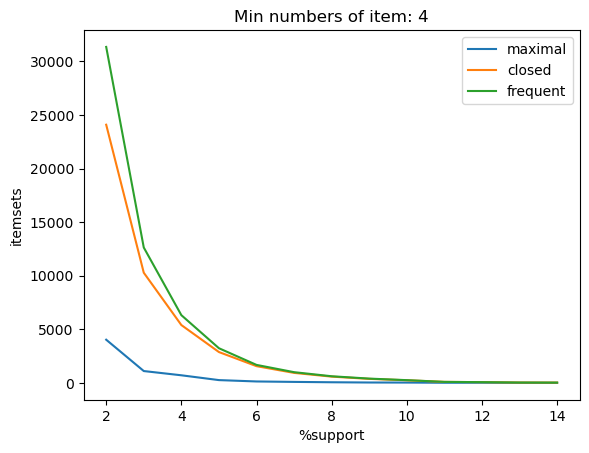

In [86]:
zmin = 4
len_max_it_4 = []
len_cl_it_4 = []
len_fr_it_4 = []
max_supp = 15
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin, zmax=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin, zmax=zmin)
    fr_itemsets = apriori(X, target="s", supp=i, zmin=zmin, zmax=zmin)
    len_max_it_4.append(len(max_itemsets))
    len_cl_it_4.append(len(cl_itemsets))
    len_fr_it_4.append(len(fr_itemsets))
plt.plot(np.arange(2, max_supp), len_max_it_4, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it_4, label="closed")
plt.plot(np.arange(2, max_supp), len_fr_it_4, label="frequent")
plt.legend()
plt.title("Min numbers of item: 4")
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

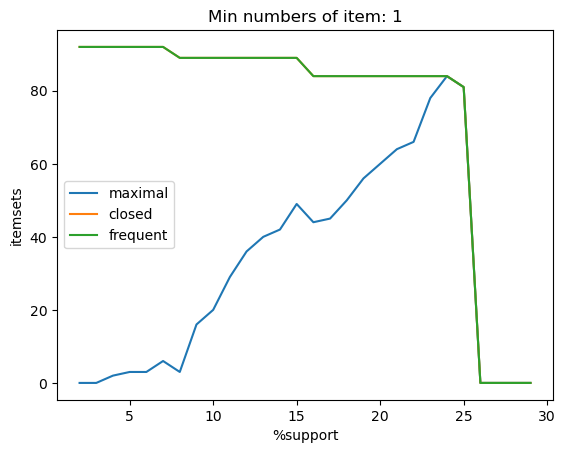

In [87]:
zmin = 1
len_max_it_1 = []
len_cl_it_1 = []
len_fr_it_1 = []
max_supp = 30
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin, zmax=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin, zmax=zmin)
    fr_itemsets = apriori(X, target="s", supp=i, zmin=zmin, zmax=zmin)
    len_max_it_1.append(len(max_itemsets))
    len_cl_it_1.append(len(cl_itemsets))
    len_fr_it_1.append(len(fr_itemsets))
plt.plot(np.arange(2, max_supp), len_max_it_1, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it_1, label="closed")
plt.plot(np.arange(2, max_supp), len_fr_it_1, label="frequent")
plt.legend()
plt.title("Min numbers of item: 1")
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

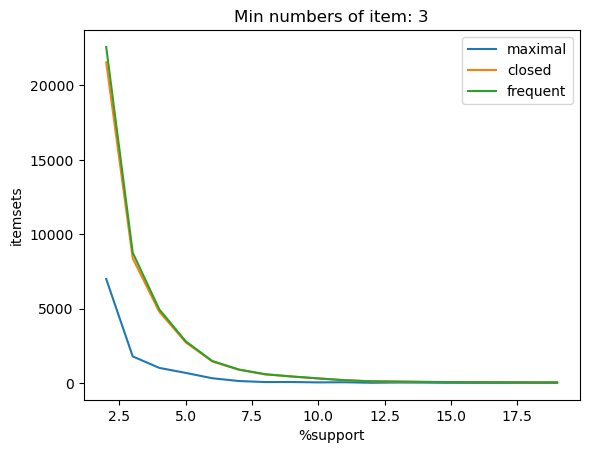

In [88]:
zmin = 3
len_max_it_3 = []
len_cl_it_3 = []
len_fr_it_3 = []
max_supp = 20
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin, zmax=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin, zmax=zmin)
    fr_itemsets = apriori(X, target="s", supp=i, zmin=zmin, zmax=zmin)
    len_max_it_3.append(len(max_itemsets))
    len_cl_it_3.append(len(cl_itemsets))
    len_fr_it_3.append(len(fr_itemsets))
plt.plot(np.arange(2, max_supp), len_max_it_3, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it_3, label="closed")
plt.plot(np.arange(2, max_supp), len_fr_it_3, label="frequent")
plt.legend()
plt.title("Min numbers of item: 3")
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

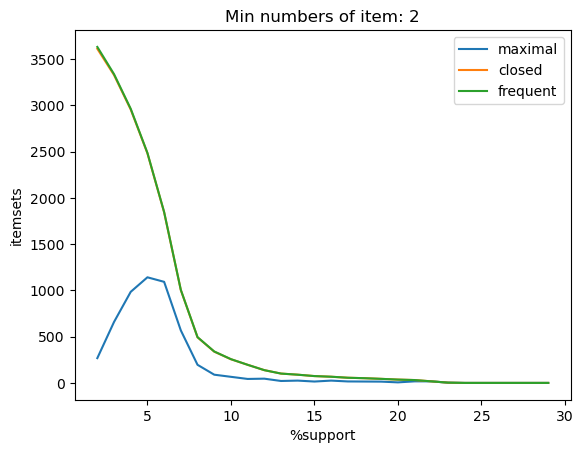

In [89]:
zmin = 2
len_max_it_2 = []
len_cl_it_2 = []
len_fr_it_2 = []
max_supp = 30
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin, zmax=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin, zmax=zmin)
    fr_itemsets = apriori(X, target="s", supp=i, zmin=zmin, zmax=zmin)
    len_max_it_2.append(len(max_itemsets))
    len_cl_it_2.append(len(cl_itemsets))
    len_fr_it_2.append(len(fr_itemsets))
plt.plot(np.arange(2, max_supp), len_max_it_2, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it_2, label="closed")
plt.plot(np.arange(2, max_supp), len_fr_it_2, label="frequent")
plt.legend()
plt.title("Min numbers of item: 2")
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

In [90]:
len_fr_it_1

[92,
 92,
 92,
 92,
 92,
 92,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 81,
 0,
 0,
 0,
 0]

In [91]:
len_fr_it_2

[3633,
 3339,
 2964,
 2487,
 1848,
 1006,
 495,
 340,
 257,
 196,
 138,
 101,
 89,
 74,
 67,
 56,
 51,
 44,
 36,
 31,
 17,
 3,
 0,
 0,
 0,
 0,
 0,
 0]

In [92]:
len_fr_it_3

[22591,
 8757,
 4949,
 2795,
 1472,
 902,
 583,
 434,
 303,
 181,
 109,
 89,
 68,
 55,
 48,
 44,
 42,
 40]

In [93]:
len_fr_it_4

[31339, 12631, 6322, 3238, 1683, 1004, 624, 405, 260, 99, 74, 38, 32]

## Association rules

Support = 10

In [94]:
rules = apriori(X, target="r", supp=10, zmin=6, zmax = 6, conf=2, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
    "consequent",
    "antecedent",
    "abs_support",
    "%_support",
    "confidence",
    "lift",
    ],
)
rules_df

,consequent,antecedent,abs_support,%_support,confidence,lift
0,neutral,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",30,1.223491,0.109091,1.422824
1,neutral,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",37,1.508972,0.121311,1.582211
2,neutral,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",34,1.386623,0.123636,1.612534
3,neutral,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",29,1.182708,0.109023,1.421932
4,neutral,"((-43.343, -37.179]_intensity, (-826.464, -760...",30,1.223491,0.114504,1.493422
...,...,...,...,...,...,...
7392,"(-1.391, -1.292]_stft_kur","((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",83,3.384992,0.287197,1.148789
7393,"(0.349, 0.392]_stft_std","((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",79,3.221860,0.273356,1.093426
7394,"(0.415, 0.476]_stft_mean","((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",82,3.344209,0.283737,1.134948
7395,"(-1.797, -1.496]_sc_kur","((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",55,2.243067,0.190311,0.761246


In [95]:
rules_list_supp10_item2 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=10, zmin=2, zmax = 2, conf=conf, report="aScl")
    rules_df_supp10_item2 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp10_item2.append(len(rules))

In [96]:
rules_list_supp10_item3 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=10, zmin=3, zmax = 3, conf=conf, report="aScl")
    rules_df_supp10_item3 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp10_item3.append(len(rules))

In [97]:
rules_list_supp10_item4 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=10, zmin=4, zmax = 4, conf=conf, report="aScl")
    rules_df_supp10_item4 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp10_item4.append(len(rules))

In [98]:
rules_list_supp10_item5 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=10, zmin=5, zmax = 5, conf=conf, report="aScl")
    rules_df_supp10_item5 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp10_item5.append(len(rules))

In [99]:
rules_list_supp10_item6 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=10, zmin=6, zmax = 6, conf=conf, report="aScl")
    rules_df_supp10_item6 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp10_item6.append(len(rules))

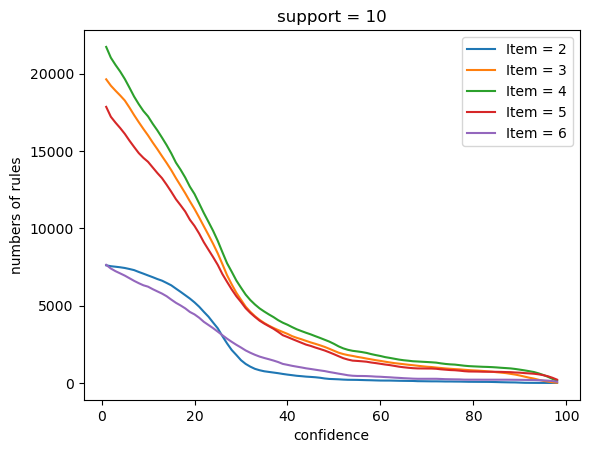

In [100]:
plt.plot(np.arange(1,99), rules_list_supp10_item2, label = "Item = 2")
plt.plot(np.arange(1,99), rules_list_supp10_item3, label = "Item = 3")
plt.plot(np.arange(1,99), rules_list_supp10_item4, label = "Item = 4")
plt.plot(np.arange(1,99), rules_list_supp10_item5, label = "Item = 5")
plt.plot(np.arange(1,99), rules_list_supp10_item6, label = "Item = 6")
plt.xlabel("confidence")
plt.ylabel("numbers of rules")
plt.title("support = 10")
plt.legend()
plt.show()

Support = 20

In [101]:
rules_list_supp20_item2 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=20, zmin=2, zmax = 2, conf=conf, report="aScl")
    rules_df_supp20_item2 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp20_item2.append(len(rules))

In [102]:
rules_list_supp20_item3 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=20, zmin=3, zmax = 3, conf=conf, report="aScl")
    rules_df_supp20_item3 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp20_item3.append(len(rules))

In [103]:
rules_list_supp20_item4 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=20, zmin=4, zmax = 4, conf=conf, report="aScl")
    rules_df_supp20_item4 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp20_item4.append(len(rules))

In [104]:
rules_list_supp20_item5 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=20, zmin=5, zmax = 5, conf=conf, report="aScl")
    rules_df_supp20_item5 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp20_item5.append(len(rules))

In [105]:
rules_list_supp20_item6 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=20, zmin=6, zmax = 6, conf=conf, report="aScl")
    rules_df_supp20_item6 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp20_item6.append(len(rules))

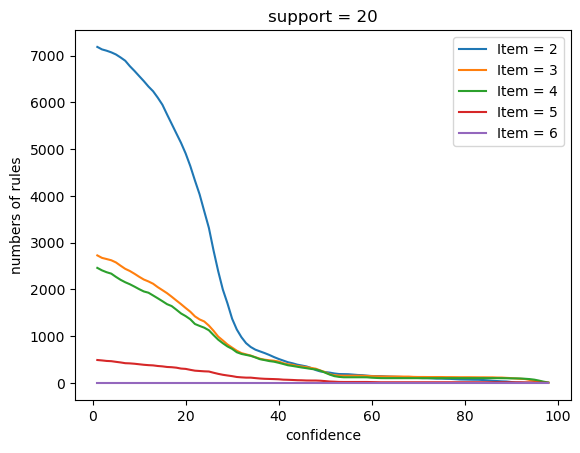

In [106]:
plt.plot(np.arange(1,99), rules_list_supp20_item2, label = "Item = 2")
plt.plot(np.arange(1,99), rules_list_supp20_item3, label = "Item = 3")
plt.plot(np.arange(1,99), rules_list_supp20_item4, label = "Item = 4")
plt.plot(np.arange(1,99), rules_list_supp20_item5, label = "Item = 5")
plt.plot(np.arange(1,99), rules_list_supp20_item6, label = "Item = 6")
plt.xlabel("confidence")
plt.ylabel("numbers of rules")
plt.title("support = 20")
plt.legend()
plt.show()

Support = 30

In [107]:
rules_list_supp30_item2 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=30, zmin=2, zmax = 2, conf=conf, report="aScl")
    rules_df_supp30_item2 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp30_item2.append(len(rules))

In [108]:
rules_list_supp30_item3 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=30, zmin=3, zmax = 3, conf=conf, report="aScl")
    rules_df_supp30_item3 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp30_item3.append(len(rules))

In [109]:
rules_list_supp30_item4 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=30, zmin=4, zmax = 4, conf=conf, report="aScl")
    rules_df_supp30_item4 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp30_item4.append(len(rules))

In [110]:
rules_list_supp30_item5 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=30, zmin=5, zmax = 5, conf=conf, report="aScl")
    rules_df_supp30_item5 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp30_item5.append(len(rules))

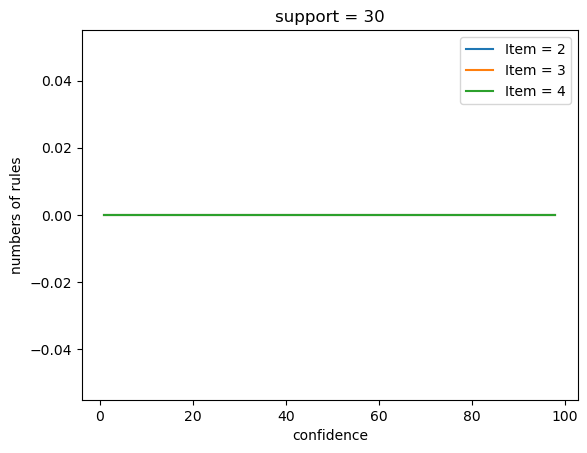

In [111]:
plt.plot(np.arange(1,99), rules_list_supp30_item2, label = "Item = 2")
plt.plot(np.arange(1,99), rules_list_supp30_item3, label = "Item = 3")
plt.plot(np.arange(1,99), rules_list_supp30_item4, label = "Item = 4")
#plt.plot(np.arange(1,99), rules_list_supp30_item5, label = "Item = 5")
plt.xlabel("confidence")
plt.ylabel("numbers of rules")
plt.title("support = 30")
plt.legend()
plt.show()

Support = 40

In [112]:
rules_list_supp40_item2 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=40, zmin=2, zmax = 2, conf=conf, report="aScl")
    rules_df_supp40_item2 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp40_item2.append(len(rules))

In [113]:
rules_list_supp40_item3 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=40, zmin=3, zmax = 3, conf=conf, report="aScl")
    rules_df_supp40_item3 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp40_item3.append(len(rules))

In [114]:
rules_list_supp40_item4 = []
for conf in range(1,99):
    rules = apriori(X, target="r", supp=40, zmin=4, zmax = 4, conf=conf, report="aScl")
    rules_df_supp40_item4 = pd.DataFrame(
        rules,
        columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
        ],
    )
    rules_list_supp40_item4.append(len(rules))

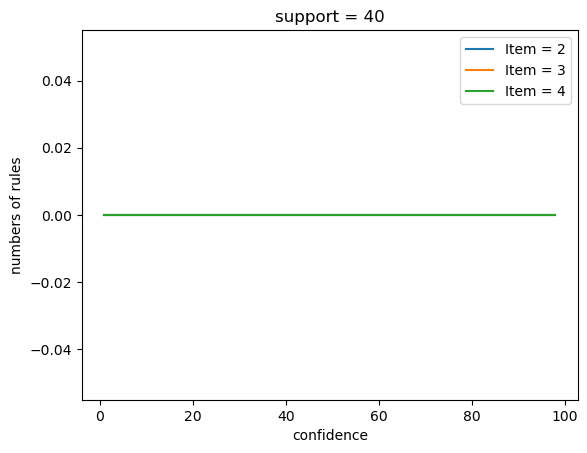

In [115]:
plt.plot(np.arange(1,99), rules_list_supp40_item2, label = "Item = 2")
plt.plot(np.arange(1,99), rules_list_supp40_item3, label = "Item = 3")
plt.plot(np.arange(1,99), rules_list_supp40_item4, label = "Item = 4")
#plt.plot(np.arange(1,99), rules_list_supp30_item5, label = "Item = 5")
plt.xlabel("confidence")
plt.ylabel("numbers of rules")
plt.title("support = 40")
plt.legend()
plt.show()

## Classification

In [123]:
rules = apriori(X, target="r", supp=10, zmin=2, conf=1, report="aScl")
rules_df = pd.DataFrame(rules, columns=["consequent", "antecedent", "abs_support", "%_support", "confidence", "lift"])

In [131]:
df.emotion.unique()

array(['fearful', 'angry', 'happy', 'neutral', 'calm', 'sad', 'surprised',
       'disgust'], dtype=object)

### Support

In [127]:
rules_df[rules_df["consequent"] == "fearful"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
8275,fearful,"((83.61999999999999, 122.624]_mfcc_std,)",161,6.566069,0.262643,1.712766
8021,fearful,"((-0.983, 3.658]_sc_kur,)",161,6.566069,0.262643,1.712766
8285,fearful,"((0.224, 0.999]_max,)",156,6.362153,0.254486,1.659574
8098,fearful,"((-692.89, -461.489]_mfcc_min,)",155,6.321370,0.252855,1.648936
8262,fearful,"((0.0262, 0.152]_std,)",155,6.321370,0.252855,1.648936


In [132]:
rules_df[rules_df["consequent"] == "angry"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
7162,angry,"((0.224, 0.999]_max,)",256,10.440457,0.417618,2.723404
7153,angry,"((-1.0, -0.202]_min,)",254,10.358891,0.414356,2.702128
7144,angry,"((-1.0, -0.202]_min, (0.224, 0.999]_max)",247,10.073409,0.434095,2.830853
7095,angry,"((0.0262, 0.152]_std,)",243,9.910277,0.396411,2.585106
6847,angry,"((-692.89, -461.489]_mfcc_min,)",240,9.787928,0.391517,2.553191


In [133]:
rules_df[rules_df["consequent"] == "happy"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
5976,happy,"((0.11, 0.224]_max,)",151,6.158238,0.246330,1.606383
5967,happy,"((-0.202, -0.104]_min,)",143,5.831974,0.233279,1.521277
6077,happy,"((-37.179, -31.509]_intensity,)",142,5.791191,0.230894,1.505726
5561,happy,"((122.624, 136.524]_mfcc_std,)",138,5.628059,0.225122,1.468085
6050,happy,"((-760.983, -692.89]_mfcc_min,)",138,5.628059,0.225122,1.468085


In [134]:
rules_df[rules_df["consequent"] == "neutral"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
428,neutral,"((151.385, 195.943]_mfcc_std,)",91,3.711256,0.148450,1.936170
714,neutral,"((3768.503, 4819.783]_sc_std,)",88,3.588907,0.143556,1.872340
199,neutral,"((-0.0544, -0.00613]_min,)",88,3.588907,0.143791,1.875400
572,neutral,"((4720.999, 10362.5]_zero_crossings_sum,)",87,3.548124,0.141925,1.851064
270,neutral,"((0.0036699999999999997, 0.0555]_max,)",86,3.507341,0.140294,1.829787


In [135]:
rules_df[rules_df["consequent"] == "calm"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
4275,calm,"((0.0036699999999999997, 0.0555]_max,)",218,8.890701,0.355628,2.319149
4203,calm,"((-0.0544, -0.00613]_min,)",216,8.809135,0.352941,2.301627
4409,calm,"((-1085.481, -826.464]_mfcc_min,)",210,8.564437,0.342577,2.234043
4437,calm,"((151.385, 195.943]_mfcc_std,)",205,8.360522,0.334421,2.180851
4359,calm,"((-0.000348, 0.00679]_std,)",204,8.319739,0.332790,2.170213


In [136]:
rules_df[rules_df["consequent"] == "sad"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
3466,sad,"((-43.814, -31.829]_mfcc_mean,)",148,6.035889,0.241436,1.574468
3184,sad,"((0.0036699999999999997, 0.0555]_max,)",145,5.913540,0.236542,1.542553
3112,sad,"((-0.0544, -0.00613]_min,)",137,5.587276,0.223856,1.459828
3897,sad,"((-63.866, -43.343]_intensity,)",134,5.464927,0.217532,1.418589
3452,sad,"((-826.464, -760.983]_mfcc_min,)",133,5.424144,0.216966,1.414894


In [137]:
rules_df[rules_df["consequent"] == "surprised"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
1381,surprised,"((-0.511, 0.0985]_sc_skew,)",122,4.975530,0.199021,2.541667
1623,surprised,"((-0.995, -0.0943]_stft_skew,)",101,4.119086,0.164763,2.104167
1741,surprised,"((5775.96, 7655.336]_sc_mean,)",101,4.119086,0.164763,2.104167
1430,surprised,"((0.531, 0.724]_stft_mean,)",92,3.752039,0.150082,1.916667
1379,surprised,"((-0.511, 0.0985]_sc_skew, (5775.96, 7655.336]...",90,3.670473,0.200893,2.565569


In [138]:
rules_df[rules_df["consequent"] == "disgust"].sort_values(by = "%_support", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
2758,disgust,"((14.085, 59.086]_kur,)",87,3.548124,0.141925,1.812500
2446,disgust,"((0.209, 0.318]_stft_std,)",85,3.466558,0.138662,1.770833
2356,disgust,"((0.00679, 0.0139]_std,)",82,3.344209,0.133768,1.708333
1776,disgust,"((-43.343, -37.179]_intensity,)",81,3.303426,0.132787,1.695799
2438,disgust,"((0.531, 0.724]_stft_mean,)",79,3.221860,0.128874,1.645833


### Confidence

In [139]:
df.emotion.unique()

array(['fearful', 'angry', 'happy', 'neutral', 'calm', 'sad', 'surprised',
       'disgust'], dtype=object)

In [140]:
rules_df[rules_df["consequent"] == "fearful"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
617,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",92,3.752039,0.343284,2.238647
621,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",87,3.548124,0.342520,2.233666
620,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",89,3.629690,0.340996,2.223730
697,fearful,"((-692.89, -461.489]_mfcc_min, (126.25, 180.08...",86,3.507341,0.339921,2.216719
696,fearful,"((-692.89, -461.489]_mfcc_min, (126.25, 180.08...",88,3.588907,0.339768,2.215723


In [141]:
rules_df[rules_df["consequent"] == "angry"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
528,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",159,6.484502,0.540816,3.526813
571,angry,"((-25.55, -15.491]_mfcc_mean, (0.0262, 0.152]_...",162,6.606852,0.540000,3.521489
525,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",160,6.525285,0.533333,3.478014
570,angry,"((-25.55, -15.491]_mfcc_mean, (-692.89, -461.4...",155,6.321370,0.530822,3.461637
526,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",159,6.484502,0.530000,3.456277


In [142]:
rules_df[rules_df["consequent"] == "happy"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
488,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",66,2.691680,0.243542,1.588208
486,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",62,2.528548,0.232210,1.514304
513,happy,"((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",67,2.732463,0.231834,1.511853
487,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",64,2.610114,0.230216,1.501301
490,happy,"((122.624, 136.524]_mfcc_std, (0.11, 0.224]_ma...",63,2.569331,0.225806,1.472546


In [143]:
rules_df[rules_df["consequent"] == "neutral"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
28,neutral,"((-0.0544, -0.00613]_min, (-1085.481, -826.464...",49,1.998369,0.189922,2.477074
25,neutral,"((-0.0544, -0.00613]_min, (-0.000348, 0.00679]...",49,1.998369,0.189189,2.467510
13,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186992,2.438851
9,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186235,2.428978
12,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186235,2.428978


In [144]:
rules_df[rules_df["consequent"] == "calm"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
383,calm,"((-0.000348, 0.00679]_std, (-1085.481, -826.46...",108,4.404568,0.430279,2.805968
375,calm,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",103,4.200653,0.418699,2.730453
369,calm,"((-0.0544, -0.00613]_min, (-1085.481, -826.464...",100,4.078303,0.403226,2.629547
348,calm,"((-0.0544, -0.00613]_min, (0.00366999999999999...",99,4.037520,0.402439,2.624416
366,calm,"((-0.0544, -0.00613]_min, (-0.000348, 0.00679]...",100,4.078303,0.401606,2.618987


In [145]:
rules_df[rules_df["consequent"] == "sad"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
257,sad,"((-0.0544, -0.00613]_min, (0.00366999999999999...",60,2.446982,0.242915,1.584116
277,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",60,2.446982,0.240000,1.565106
280,sad,"((0.0036699999999999997, 0.0555]_max, (-1085.4...",60,2.446982,0.240000,1.565106
279,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",60,2.446982,0.239044,1.558871
275,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",59,2.406199,0.235060,1.532890


In [146]:
rules_df[rules_df["consequent"] == "surprised"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
127,surprised,"((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",37,1.508972,0.128028,1.635020
113,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",32,1.305057,0.119850,1.530587
117,surprised,"((122.624, 136.524]_mfcc_std, (0.11, 0.224]_ma...",33,1.345840,0.118280,1.510529
116,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",34,1.386623,0.116838,1.492125
114,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",32,1.305057,0.115108,1.470024


In [147]:
rules_df[rules_df["consequent"] == "disgust"].sort_values(by = "confidence", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
194,disgust,"((0.00679, 0.0139]_std, (-826.464, -760.983]_m...",37,1.508972,0.145669,1.860318
131,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",38,1.549755,0.142857,1.824405
132,disgust,"((-43.343, -37.179]_intensity, (-826.464, -760...",37,1.508972,0.141221,1.803515
130,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",38,1.549755,0.138182,1.764697
128,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",37,1.508972,0.134545,1.718258


### Lift

In [148]:
df.emotion.unique()

array(['fearful', 'angry', 'happy', 'neutral', 'calm', 'sad', 'surprised',
       'disgust'], dtype=object)

In [149]:
rules_df[rules_df["consequent"] == "fearful"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
617,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",92,3.752039,0.343284,2.238647
621,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",87,3.548124,0.342520,2.233666
620,fearful,"((-31.509, 253058.198]_intensity, (-692.89, -4...",89,3.629690,0.340996,2.223730
697,fearful,"((-692.89, -461.489]_mfcc_min, (126.25, 180.08...",86,3.507341,0.339921,2.216719
696,fearful,"((-692.89, -461.489]_mfcc_min, (126.25, 180.08...",88,3.588907,0.339768,2.215723


In [151]:
rules_df[rules_df["consequent"] == "angry"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
528,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",159,6.484502,0.540816,3.526813
571,angry,"((-25.55, -15.491]_mfcc_mean, (0.0262, 0.152]_...",162,6.606852,0.540000,3.521489
525,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",160,6.525285,0.533333,3.478014
570,angry,"((-25.55, -15.491]_mfcc_mean, (-692.89, -461.4...",155,6.321370,0.530822,3.461637
526,angry,"((-31.509, 253058.198]_intensity, (-25.55, -15...",159,6.484502,0.530000,3.456277


In [152]:
rules_df[rules_df["consequent"] == "happy"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
488,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",66,2.691680,0.243542,1.588208
486,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",62,2.528548,0.232210,1.514304
513,happy,"((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",67,2.732463,0.231834,1.511853
487,happy,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",64,2.610114,0.230216,1.501301
490,happy,"((122.624, 136.524]_mfcc_std, (0.11, 0.224]_ma...",63,2.569331,0.225806,1.472546


In [153]:
rules_df[rules_df["consequent"] == "neutral"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
28,neutral,"((-0.0544, -0.00613]_min, (-1085.481, -826.464...",49,1.998369,0.189922,2.477074
25,neutral,"((-0.0544, -0.00613]_min, (-0.000348, 0.00679]...",49,1.998369,0.189189,2.467510
13,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186992,2.438851
9,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186235,2.428978
12,neutral,"((-0.0544, -0.00613]_min, (0.00366999999999999...",46,1.876020,0.186235,2.428978


In [154]:
rules_df[rules_df["consequent"] == "calm"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
383,calm,"((-0.000348, 0.00679]_std, (-1085.481, -826.46...",108,4.404568,0.430279,2.805968
375,calm,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",103,4.200653,0.418699,2.730453
369,calm,"((-0.0544, -0.00613]_min, (-1085.481, -826.464...",100,4.078303,0.403226,2.629547
348,calm,"((-0.0544, -0.00613]_min, (0.00366999999999999...",99,4.037520,0.402439,2.624416
366,calm,"((-0.0544, -0.00613]_min, (-0.000348, 0.00679]...",100,4.078303,0.401606,2.618987


In [155]:
rules_df[rules_df["consequent"] == "sad"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
257,sad,"((-0.0544, -0.00613]_min, (0.00366999999999999...",60,2.446982,0.242915,1.584116
277,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",60,2.446982,0.240000,1.565106
280,sad,"((0.0036699999999999997, 0.0555]_max, (-1085.4...",60,2.446982,0.240000,1.565106
279,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",60,2.446982,0.239044,1.558871
275,sad,"((0.0036699999999999997, 0.0555]_max, (-0.0003...",59,2.406199,0.235060,1.532890


In [156]:
rules_df[rules_df["consequent"] == "surprised"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
127,surprised,"((-0.202, -0.104]_min, (0.11, 0.224]_max, (0.0...",37,1.508972,0.128028,1.635020
113,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",32,1.305057,0.119850,1.530587
117,surprised,"((122.624, 136.524]_mfcc_std, (0.11, 0.224]_ma...",33,1.345840,0.118280,1.510529
116,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",34,1.386623,0.116838,1.492125
114,surprised,"((122.624, 136.524]_mfcc_std, (-0.202, -0.104]...",32,1.305057,0.115108,1.470024


In [157]:
rules_df[rules_df["consequent"] == "disgust"].sort_values(by = "lift", ascending = False).head(5)#.to_string()

,consequent,antecedent,abs_support,%_support,confidence,lift
194,disgust,"((0.00679, 0.0139]_std, (-826.464, -760.983]_m...",37,1.508972,0.145669,1.860318
131,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",38,1.549755,0.142857,1.824405
132,disgust,"((-43.343, -37.179]_intensity, (-826.464, -760...",37,1.508972,0.141221,1.803515
130,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",38,1.549755,0.138182,1.764697
128,disgust,"((-43.343, -37.179]_intensity, (0.00679, 0.013...",37,1.508972,0.134545,1.718258


## FP-Growth

In [120]:
help(fpgrowth)

Help on built-in function fpgrowth in module fim:

fpgrowth(...)
    fpgrowth (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
              eval='x', agg='x', thresh=10, prune=Nobe, algo='s', mode='',
              border=None)
    Find frequent item sets with the FP-growth algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support 

In [121]:
supp = 2  # 2%
supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = fpgrowth(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((0.0555, 0.11]_max, (-0.104, -0.0544]_min)",20.228385
1,"((151.385, 195.943]_mfcc_std, (-63.866, -43.34...",22.593801
2,"((-692.89, -461.489]_mfcc_min, (0.0262, 0.152]...",22.267537
3,"((0.531, 0.724]_stft_mean, (-0.995, -0.0943]_s...",22.512235
4,"((0.0036699999999999997, 0.0555]_max, (-63.866...",20.799347
...,...,...
72,"((-31.509, 253058.198]_intensity, (0.224, 0.99...",20.391517
73,"((-31.509, 253058.198]_intensity, (0.224, 0.99...",20.350734
74,"((-31.509, 253058.198]_intensity, (0.224, 0.99...",20.636215
75,"((-31.509, 253058.198]_intensity, (0.224, 0.99...",21.247961


In [122]:
conf = 70
rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")
pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)

,consequent,antecedent,abs_support,%_support,confidence,lift
0,"(-0.0943, 0.126]_stft_skew","((0.476, 0.531]_stft_mean,)",461,18.800979,0.752039,3.008157
1,"(0.476, 0.531]_stft_mean","((-0.0943, 0.126]_stft_skew,)",461,18.800979,0.752039,3.008157
2,"(-0.104, -0.0544]_min","((-826.464, -760.983]_mfcc_min,)",450,18.352365,0.734095,2.931596
3,"(-826.464, -760.983]_mfcc_min","((-0.104, -0.0544]_min,)",450,18.352365,0.732899,2.931596
4,"(0.00679, 0.0139]_std","((-826.464, -760.983]_mfcc_min,)",445,18.148450,0.725938,2.903752
...,...,...,...,...,...,...
344,"(-826.464, -760.983]_mfcc_min","((-43.343, -37.179]_intensity,)",477,19.453507,0.781967,3.127869
345,"(-43.343, -37.179]_intensity","((-826.464, -760.983]_mfcc_min,)",477,19.453507,0.778140,3.127869
346,"(136.524, 151.385]_mfcc_std","((-43.343, -37.179]_intensity, (0.00679, 0.013...",451,18.393148,0.820000,3.280000
347,"(136.524, 151.385]_mfcc_std","((-43.343, -37.179]_intensity,)",477,19.453507,0.781967,3.127869
